In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from crnn.utils import base as utils
from crnn.configuration.experiment import BaseExperimentConfig, BaseModelConfig
# from crnn.data_io import get_result_directory_name, load_data, load_normalization
from crnn.io.data import get_result_directory_name, load_data, load_normalization
from crnn.io.model import get_model_from_config, load_model
from crnn.models.base import retrieve_model_class
from crnn.datasets import RecurrentWindowHorizonDataset
import torch
import numpy as np
import matplotlib.pyplot as plt

import json
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
model_name = 'lstm'
experiment_name = 'F16-128'
result_base_directory = '/Users/jack/F16/2025_06_24/'
model_class_name = 'crnn.models.recurrent.BasicLstm'
dataset_directory = '/Users/jack/F16/data/processed'
torch.set_default_dtype(torch.double)

In [42]:
mode = "test"
result_directory = get_result_directory_name(
    result_base_directory, model_name, experiment_name
)

experiment_model_name = f'{experiment_name}-{model_name}'
with open(os.path.join(result_directory,f'{utils.get_config_file_name("experiment", experiment_model_name)}.json'), mode="r") as f:
    experiment_dict = json.load(f)
experiment_config = BaseExperimentConfig(**experiment_dict)

model_class = retrieve_model_class(model_class_name)
with open(os.path.join(result_directory,f'{utils.get_config_file_name("model", experiment_model_name)}.json'), mode="r") as f:
    model_dict = json.load(f)
model_config = BaseModelConfig(m_class=model_class_name, parameters=model_class.CONFIG(**model_dict))


In [43]:
import nonlinear_benchmarks

# Load data: 
# Keep this part fixed, though you can split the train set further in a train and validation set. 
# Do not use the test set to make any decision about the model (parameters, hyperparameters, structure, ...)
trains, tests = nonlinear_benchmarks.F16(atleast_2d=True, always_return_tuples_of_datasets=True, output_index=[0,1,2])
n = tests[0].state_initialization_window_length

test_inputs = [io_data.u for io_data in tests]
test_outputs = [io_data.y for io_data in tests]
test_outputs[0].shape
tests


(Input_output_data "F16Data_FullMSine_Level2_Validation.mat" u.shape=(73728, 1) y.shape=(73728, 3) sampling_time=0.0025 state_initialization_window_length=50,
 Input_output_data "F16Data_FullMSine_Level4_Validation.mat" u.shape=(73728, 1) y.shape=(73728, 3) sampling_time=0.0025 state_initialization_window_length=50,
 Input_output_data "F16Data_FullMSine_Level6_Validation.mat" u.shape=(73728, 1) y.shape=(73728, 3) sampling_time=0.0025 state_initialization_window_length=50,
 Input_output_data "F16Data_SineSw_Level2_Validation.mat" u.shape=(108477, 1) y.shape=(108477, 3) sampling_time=0.0025 state_initialization_window_length=50,
 Input_output_data "F16Data_SineSw_Level4_Validation.mat" u.shape=(116736, 1) y.shape=(116736, 3) sampling_time=0.0025 state_initialization_window_length=50,
 Input_output_data "F16Data_SineSw_Level6_Validation.mat" u.shape=(108477, 1) y.shape=(108477, 3) sampling_time=0.0025 state_initialization_window_length=50)

In [44]:
from scipy.signal import welch
# PSD
def plot_PSD(input, fs = 400, name = 'unknown', xlimits = [0,20]):
    N, n = input.shape
    for n_i in range(n):
        f, Puu = welch(input[:,n_i], fs, nperseg=1024)
        fig, ax = plt.subplots(figsize=(10,5))
        ax.semilogy(f, Puu, label=fr"S_{{{name}}}")
        ax.set_xlabel(f"Frequency [Hz], fs = {fs}")
        ax.set_ylabel("Power Spectral Density")
        ax.set_title(f"Power Spectral Densities - {name}, output: {n_i+1}")
        ax.legend()
        ax.set_xlim(xlimits)
        ax.grid()

def plot_PSD_outputs(outputs, fs = 400, name = 'unknown', xlimits = [0,20]):
    e, e_hat = outputs
    N, n = e.shape
    for n_i in range(n):
        f, Pee = welch(e[:,n_i], fs, nperseg=1024)
        _, Pee_hat = welch(e_hat[:,n_i], fs, nperseg=1024)
        fig, ax = plt.subplots(figsize=(10,5))
        ax.semilogy(f, Pee, label=r"$S_{yy}$")
        ax.semilogy(f, Pee_hat, label=r"$S_{\hat{y}\hat{y}}$")
        ax.set_xlabel(f"Frequency [Hz], fs = {fs}")
        ax.set_ylabel("Power Spectral Density")
        title = f"Power Spectral Densities - {name} output {n_i+1}"
        ax.set_title(title)
        ax.grid()
        ax.set_xlim(xlimits)
        ax.legend()
        plt.savefig(f'./fig/f16-2/{title}.png')

def dft(x, dt = 1/400):
    N, nx = x.shape
    # compute the FFT
    D_fft = np.zeros_like(x)
    for n_idx in range(nx):
        D_fft[:,n_idx] = np.fft.fft(x[:, n_idx])
        freqs = np.fft.fftfreq(N, d=dt)  # calculate the frequency bins

    return D_fft, freqs

def plot_frequencies(E, freqs):
    N, ne = E.shape
    for n_idx in range(ne):
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(freqs[:N//2], np.abs(E[:N//2, n_idx]), label=f'$E_{n_idx+1}$')  # only plot the positive frequencies
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')
        ax.set_title('Frequency Spectrum')
        ax.grid()
        ax.legend()

def plot_signal(sig, dt = 1/400, name = '',xlimits = None):
    N, n_sig = sig.shape
    if xlimits is None:
        xlimits = [0, N*dt]
    t = np.linspace(0,(N-1)*dt, N)
    for n in range(n_sig):
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(t,sig[:,n], label=fr'${name}_{{{n+1}}}$')
        ax.grid()
        ax.set_xlabel(f'Time [s], dt = {dt}')
        ax.legend()
        title = f'{name} {n+1}'
        # ax.set_title(title)
        ax.set_xlim(xlimits)
        plt.savefig(f'./fig/f16-2/{title}.png')

def plot_outputs(sigs, dt = 1/400, name = '', xlimits = None):
    e, e_hat = sigs
    N, n_sig = e.shape
    if xlimits is None:
        xlimits = [0, N*dt]
    t = np.linspace(0,(N-1)*dt, N)
    for n in range(n_sig):
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(t,e[:,n], label='$y$')
        ax.plot(t,e_hat[:,n], label=r'$\hat{y}$')
        ax.grid()
        ax.set_xlabel(f'Time [s], dt = {dt}')
        ax.legend()
        ax.set_xlim(xlimits)
        title = f"{name} output {n+1}"
        ax.set_title(title)
        plt.savefig(f'./fig/f16-2/{title}.png')

Input_output_data "F16Data_SineSw_Level3.mat" u.shape=(108477, 1) y.shape=(108477, 3) sampling_time=0.0025 state_initialization_window_length=50
(108477, 3)


/var/folders/20/k44l3vsj03x1v_37v25mlp4w0000gn/T/ipykernel_32896/1934881802.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,5))
/var/folders/20/k44l3vsj03x1v_37v25mlp4w0000gn/T/ipykernel_32896/1934881802.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  D_fft[:,n_idx] = np.fft.fft(x[:, n_idx])


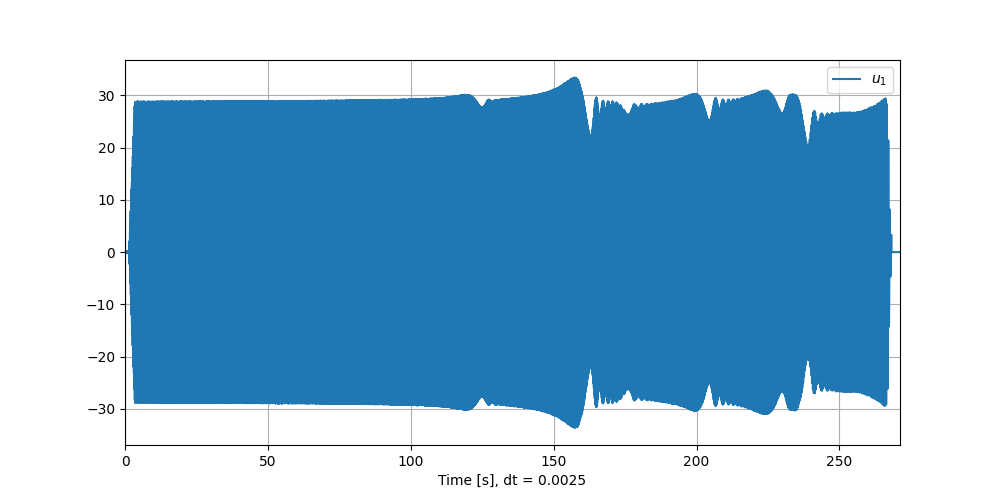

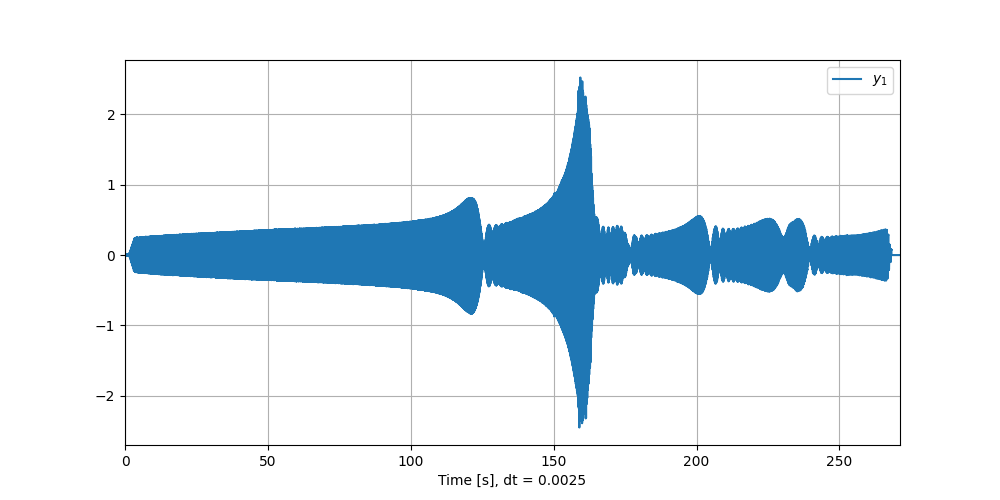

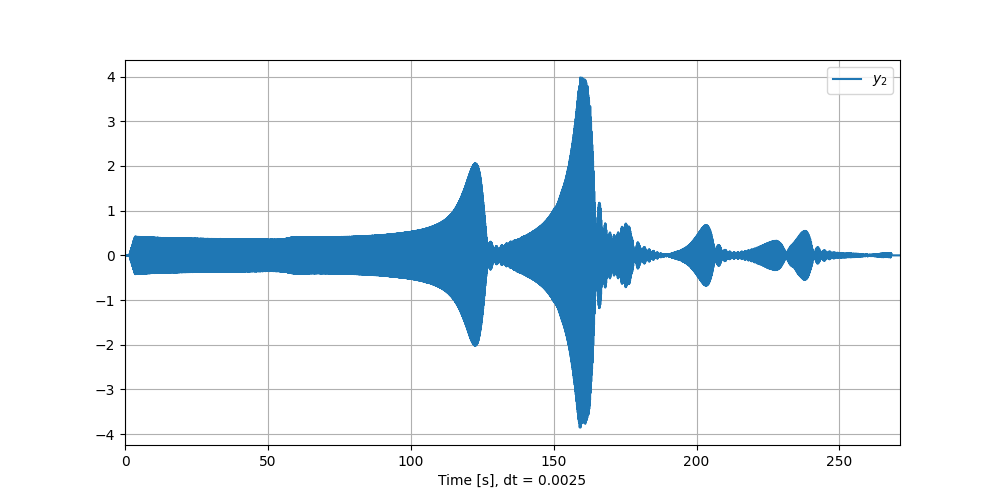

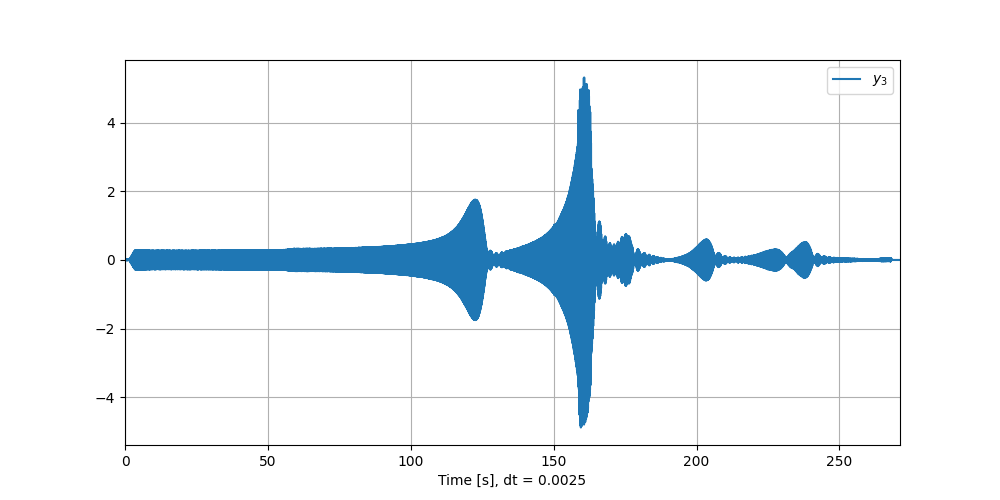

In [45]:
test_no = 5
# plot some of the training inputs
print(trains[test_no])
u = trains[test_no].u
y = trains[test_no].y

fs = 400
dt = 1/fs

print(y.shape)

plot_signal(u, dt, 'u' )
plot_signal(y,dt, 'y')
U, f = dft(u, dt)
Y, _ = dft(y,dt)
# plot_PSD(u, fs, name='u', xlimits=[0, 100])
# plot_PSD(y, fs, name='y', xlimits=[0, 100])
# plot_frequencies(U, f)
# plot_frequencies(Y, f)




    


In [46]:
normalization = load_normalization(result_directory)
n_test_inputs = utils.normalize(
    test_inputs, normalization.input.mean, normalization.input.std
)

initializer, predictor = get_model_from_config(model_config)
initializer, predictor = load_model(
    experiment_config, initializer, predictor, experiment_model_name, result_directory
)

y_tests_model = []
for d in n_test_inputs:
    e_hat_n, x = predictor.forward(torch.tensor(np.expand_dims(d,0)))
    e_hat = utils.denormalize(e_hat_n.detach().numpy(), normalization.output.mean, normalization.output.std)[0]
    y_tests_model.append(e_hat)



In [47]:
np.mean(tests[0].y, axis=0)

array([ 3.22834286e-07, -6.85741597e-06, -1.50564720e-05])

In [49]:
# generate some noise
np.random.seed(42)

ys_noise = []
means, stds = [], []
for io_data in tests:
    N, ne = io_data.y.shape
    mean = np.mean(io_data.y, axis=0)
    std = np.std(io_data.y, axis=0)
    y_noise = np.random.normal(mean,0.5*std,size=(N,ne))
    # plot_outputs((io_data.y, y_noise), name=f'noise m: {mean}, std: {std}')
    ys_noise.append(y_noise)

In [59]:
from nonlinear_benchmarks.error_metrics import RMSE
scale_rmse = 1

def compare_predictions(io_datas, e_hats, name=''):
    print(f'--- Comparison: {name} ---')
    all_RMSEs = []
    all_psd_RMSEs = []
    for i, (io_data, e_hat) in enumerate(zip(io_datas, e_hats)):
        e = io_data.y
        d = io_data.u
        N, ne = e.shape
        # shift e_hat a bit
        e_hat = np.vstack((np.zeros((7,ne)), e_hat))[:N]
        # print(e_hat_2.shape)
        n_eval = N - n
        plot_PSD_outputs((e[:,0].reshape(-1,1),e_hat[:,0].reshape(-1,1)), name = f'{name} {io_data.name}', xlimits=[0,100])
        plot_outputs((e[:,0].reshape(-1,1),e_hat[:,0].reshape(-1,1)), name = f'{name} {io_data.name}', xlimits=[123,125])


        # print('-- RMSE --')
        test_RMSE = scale_rmse*RMSE(e[-n_eval:], e_hat[-n_eval:])
        all_RMSEs.append(test_RMSE)
        # print(f'test set {i+1}, {test_RMSE[0] = :.2f} mv')
        print(f'RMSE, mean: {i+1}, {test_RMSE.mean() = :.2f} mv')
        

        # for now only consider first output
        # print('-- PSD RMSE --')
        test_psd_RMSE = np.zeros(ne)
        for n_i in range(ne):
            f, S_ee = welch(e[:,n_i], fs, nperseg=1024)
            _, S_hat_ee = welch(e_hat[:,n_i], fs, nperseg=1024)
            # idx = np.where(f<15)

            test_psd_RMSE[n_i] = 1000*RMSE(S_ee, S_hat_ee)
        all_psd_RMSEs.append(test_psd_RMSE)
        print(f'PSD-RMSE mean: {i+1}, {test_psd_RMSE.mean() = :.2f} mv')

    print('RMSE to submit = [', *(f"{x}\n" for x in all_RMSEs), ']')
    print('PSD RMSE to submit = [', *(f"{x}\n" for x in all_psd_RMSEs), ']')
    return all_RMSEs


In [60]:
len(tests)
tests[5]

Input_output_data "F16Data_SineSw_Level6_Validation.mat" u.shape=(108477, 1) y.shape=(108477, 3) sampling_time=0.0025 state_initialization_window_length=50

Input_output_data "F16Data_SineSw_Level6_Validation.mat" u.shape=(108477, 1) y.shape=(108477, 3) sampling_time=0.0025 state_initialization_window_length=50
--- Comparison: noise ---
RMSE, mean: 1, test_RMSE.mean() = 1.22 mv
PSD-RMSE mean: 1, test_psd_RMSE.mean() = 36.70 mv
RMSE to submit = [ [1.04620247 1.37216115 1.23278096]
 ]
PSD RMSE to submit = [ [20.73684345 51.54008423 37.82190482]
 ]
--- Comparison: predictions ---
RMSE, mean: 1, test_RMSE.mean() = 1.17 mv
PSD-RMSE mean: 1, test_psd_RMSE.mean() = 24.92 mv
RMSE to submit = [ [0.9699465  1.35764625 1.18347507]
 ]
PSD RMSE to submit = [ [ 8.94365556 37.88026918 27.92464181]
 ]


[array([0.9699465 , 1.35764625, 1.18347507])]

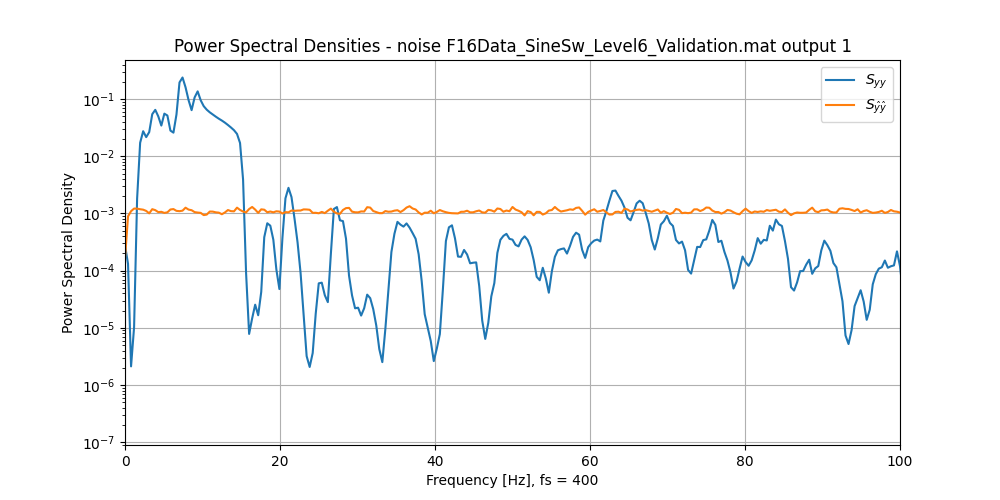

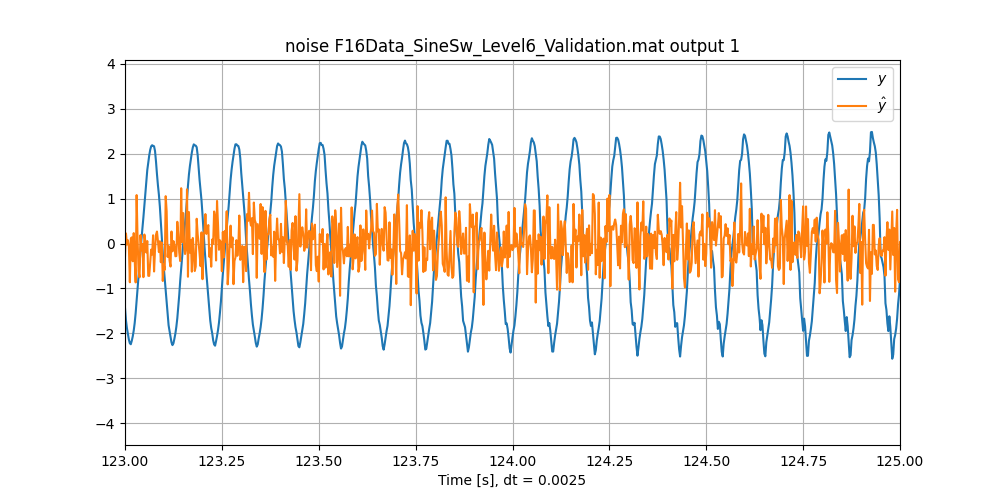

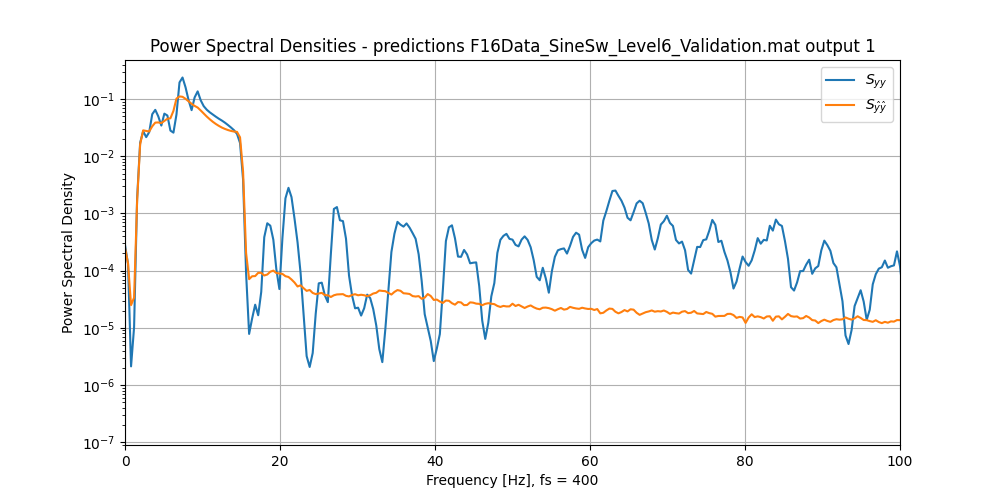

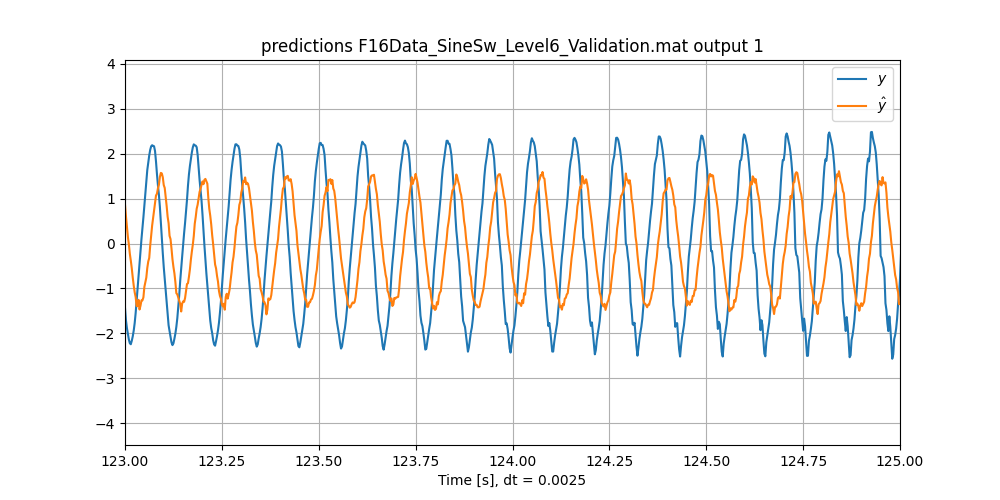

In [61]:
n_test = 5
print(tests[n_test])
compare_predictions([tests[n_test]], [ys_noise[n_test]], 'noise')
compare_predictions([tests[n_test]], [y_tests_model[n_test]], 'predictions')
# compare_predictions(tests, ys_noise, 'noise')
# compare_predictions(tests, y_tests_model, 'predictions')

In [ ]:
# load baseline results
from numpy import load
# data = load('/Users/jack/Documents/01_Git/01_promotion/nonlinear_baselines/results/LSTM_F16.npz')
data = load('/Users/jack/cloud_privat/03_Promotion/_transfer/LSTM_F16.npz')
y_baseline = []
for y_baseline_name in data:
    if 'test' in y_baseline_name:
        y_baseline.append(data[y_baseline_name])

# data['score']
y_baseline[0]

array([-0.24639301, -0.46147078, -0.547217  , ...,  0.06520532,
        0.02831058, -0.00984098], dtype=float32)

In [ ]:
print(tests[0].y.shape)
y_baseline[0].shape

(73728, 3)


(73721,)

In [ ]:
# Compute RMSE in mm (milimeters) and print results: 
# Keep this functionally unchanged
from nonlinear_benchmarks.error_metrics import RMSE
scale_rmse = 1

all_RMSEs = []
all_RMSEs_b = []
for i, test, prediction, y_b in zip(range(len(tests)), tests, y_tests_model, y_baseline):
    n_eval = y_b.shape[0] - n
    test_RMSE = scale_rmse*RMSE(test.y[-n_eval:], prediction[-n_eval:])
    test_RMSE_baseline = scale_rmse*RMSE(test.y[-n_eval:, 0], y_b[-n_eval:])
    all_RMSEs.append(test_RMSE)
    print(f'test set {i+1}, {test_RMSE[0] = :.2f} mv')
    print(f'[BASELINE] test set {i+1}, {test_RMSE_baseline = :.2f} mv')

print('RMSE to submit = [', *(f"{x[0]:.2f}" for x in all_RMSEs), ']') # report this number during submission




test set 1, test_RMSE[0] = 0.29 mv
[BASELINE] test set 1, test_RMSE_baseline = 0.29 mv
test set 2, test_RMSE[0] = 0.51 mv
[BASELINE] test set 2, test_RMSE_baseline = 0.51 mv
test set 3, test_RMSE[0] = 0.66 mv
[BASELINE] test set 3, test_RMSE_baseline = 0.66 mv
test set 4, test_RMSE[0] = 0.18 mv
[BASELINE] test set 4, test_RMSE_baseline = 0.18 mv
test set 5, test_RMSE[0] = 0.29 mv
[BASELINE] test set 5, test_RMSE_baseline = 0.31 mv
test set 6, test_RMSE[0] = 0.43 mv
[BASELINE] test set 6, test_RMSE_baseline = 0.42 mv
RMSE to submit = [ 0.29 0.51 0.66 0.18 0.29 0.43 ]


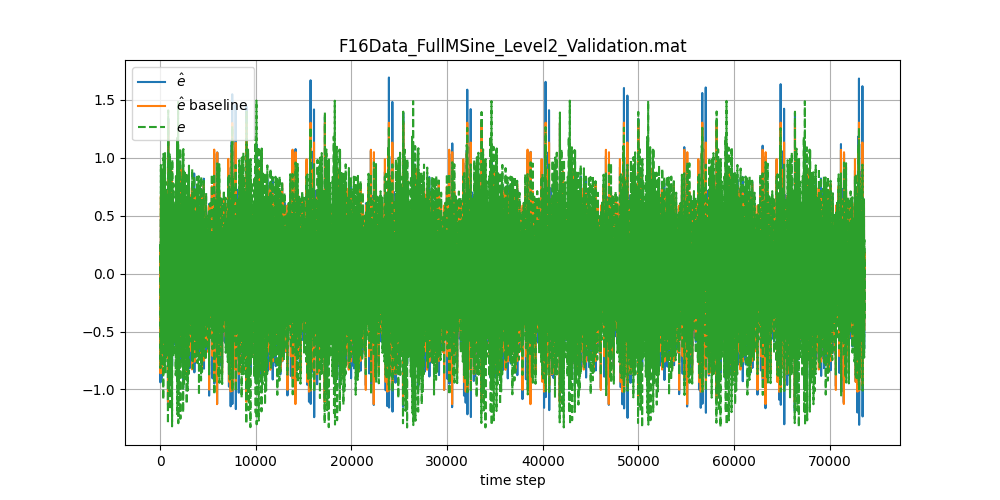

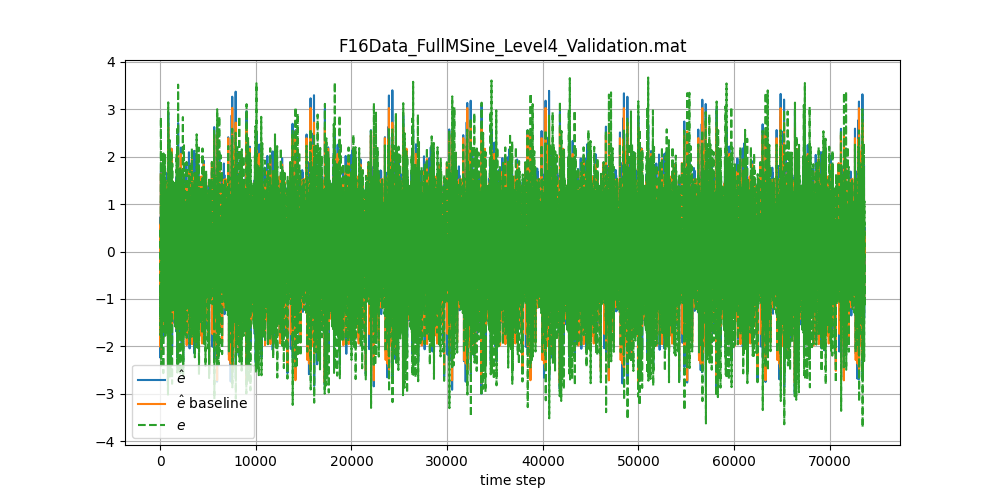

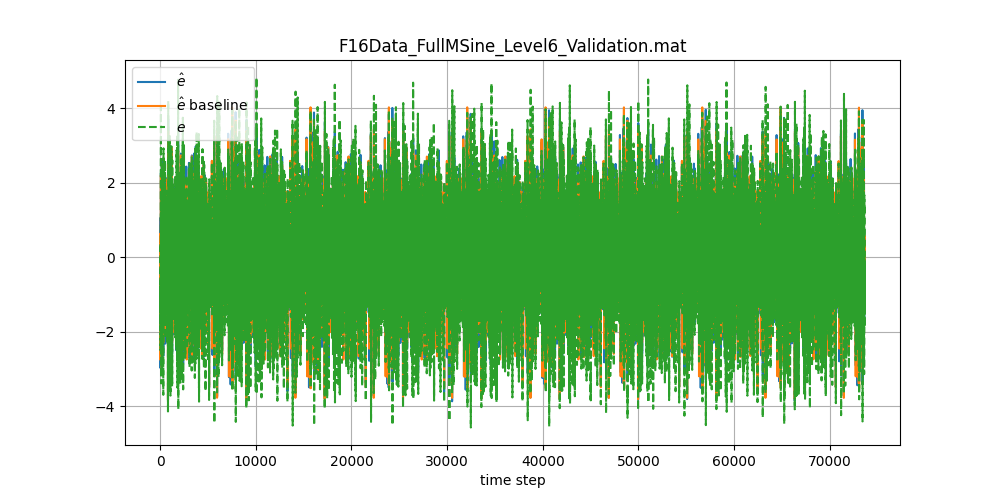

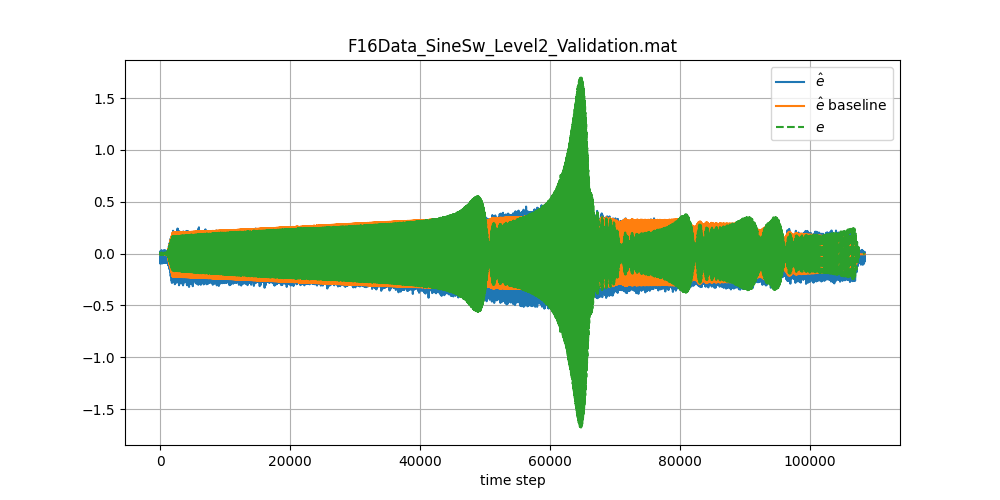

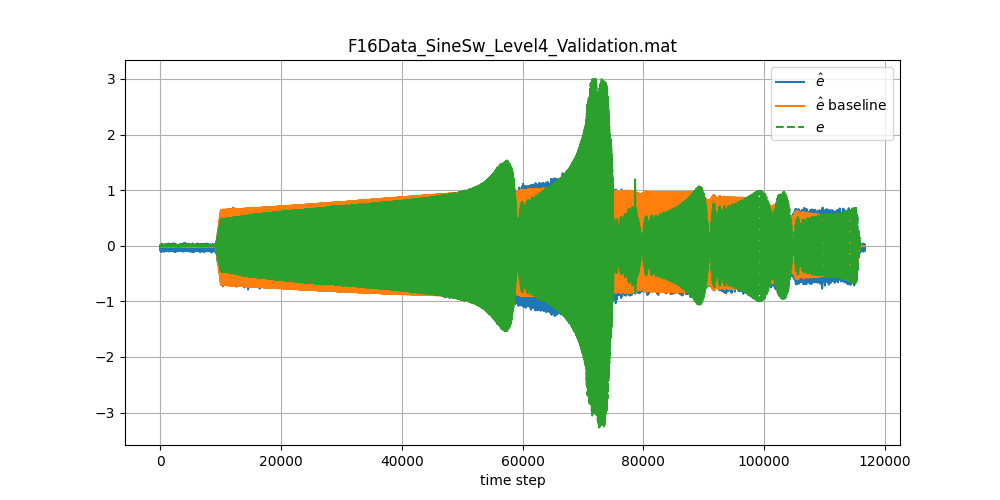

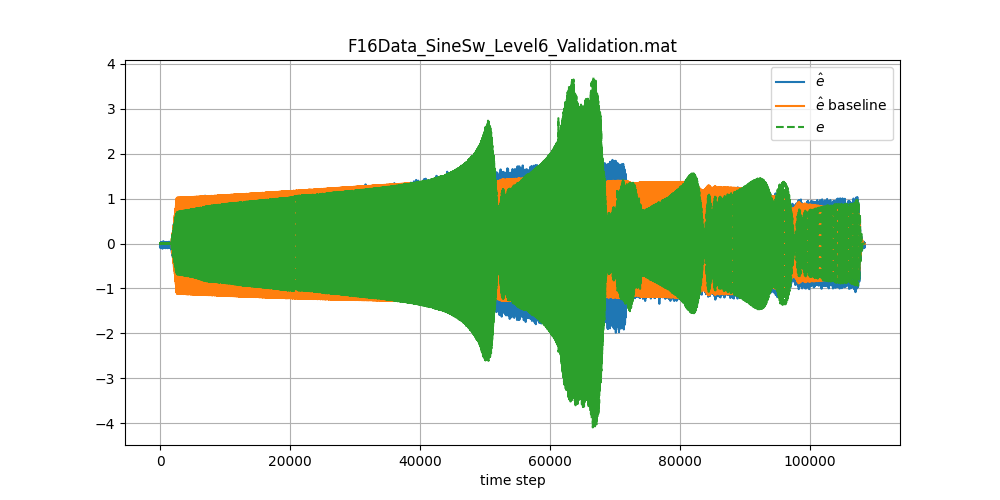

In [ ]:
for e_hat, io_data, e_hat_b in zip(y_tests_model, tests, y_baseline):    
    n_eval = e_hat_b.shape[0] - n
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title(io_data.name)
    ax.plot(e_hat[-n_eval:,0], label=r'$\hat e$')
    ax.plot(e_hat_b[-n_eval:], label=r'$\hat e$ baseline')
    ax.plot(io_data.y[-n_eval:,0],'--', label='$e$')
    ax.set_xlabel('time step')
    ax.legend()
    ax.grid()

In [ ]:
# load baseline results
from numpy import load
data = load('/Users/jack/Documents/01_Git/01_promotion/nonlinear_baselines/results/LSTM_F16.npz')
for y_baseline_name in data:
    if 'test' in y_baseline_name:
        print(data[y_baseline_name].shape)

(73727, 1)
(73727, 1)
(73727, 1)
(108476, 1)
(116735, 1)
(108476, 1)
